# Trabajo Práctico 2: Arboles de Decision

## Configuraciones iniciales:

In [1]:
import pandas as pd
import numpy as np
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import SVG, display

from sklearn import tree
from sklearn.tree import plot_tree

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV

RANDOM_STATE = 19 * 103785

## Árboles de decisión:

Los árboles de decisión de clasificación son modelos que buscan separar a todas las instancias utilizando la información que nos otorgan los feature, de modo que los nodos más profundos sean lo "más puros" posible. Es decir que en ellos quede una distribución homogénea de las clases que estamos tratando de predecir.

Existen varios hiperparametros a la hora de entrenar un árbol: 

+ criterion : Es el criterio con el cual se selecciona la nueva "regla de decisión" que separará el nodo actual en dos nuevos nodos.

+ max_depth : La profundidad máxima del árbol.

+ min_samples_leaf : La mínima cantidad de instancias que puede tener un nodo.

+ class_weight : Un peso que se le agrega para darle más importancia a la clase menos representativa.


## Funciones auxiliares:

In [2]:
from preprocesamiento import escribir_predicciones_a_archivo

def plot_tree(arbol,data):
    dot_data = tree.export_graphviz(
        arbol,
        out_file=None,
        feature_names=data.columns,
        filled=True,
        rounded=True,
        special_characters=True,
    )
    graph = graphviz.Source(dot_data)
    display(SVG(graph.pipe(format='svg')))

## Preprocesamiento

In [3]:
from preprocesamiento import obtenerDFHoldout, obtenerDFTraining
from preprocesamiento import preprocesar_data_frame
from preprocesamiento import feature_engineering
from preprocesamiento import metricas
from preprocesamiento import prepros_dummies
from preprocesamiento import preprocesar_variables_numericas

In [4]:
df = obtenerDFTraining()
(X,y) = preprocesar_data_frame(df)
X_prepos = prepros_dummies(X[['ganancia_perdida_declarada_bolsa_argentina','trabajo',
                              'estado_marital','genero',"anios_estudiados", "edad"]])
X_prepos = preprocesar_variables_numericas(X_prepos)

X_train, X_test, y_train, y_test = train_test_split(X_prepos, y, test_size=0.25, random_state=RANDOM_STATE)

Inicialmente utilizaremos un GridSearch buscando los mejores hiperparametros: Probamos distintos criterios de selección, distintas alturas, mínimos elementos en nodos y distintos pesos para el alto y bajo poder adquisitivo.

In [5]:
parametros = {'criterion' : ('gini','entropy') , 'max_depth':range(2,10), 
              'min_samples_leaf':(1,250,500,1000),
              "class_weight" :  [{0: 1,1: 1},{0: 1,1: 1.25},{0: 1,1: 1.5},{0: 1,1: 2}],
              'random_state':[RANDOM_STATE]} 

arbol = tree.DecisionTreeClassifier()
clf = GridSearchCV(arbol, parametros, scoring = "roc_auc",n_jobs= -1, verbose = 0, cv= 10)

clf.fit(X_train, y_train)
print(classification_report(y_test,clf.predict(X_test)))
clf.best_params_

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      6196
           1       0.60      0.68      0.64      1936

    accuracy                           0.82      8132
   macro avg       0.75      0.77      0.76      8132
weighted avg       0.83      0.82      0.82      8132



{'class_weight': {0: 1, 1: 2},
 'criterion': 'gini',
 'max_depth': 9,
 'min_samples_leaf': 250,
 'random_state': 1971915}

Una vez tenemos el mejor modelo lo entrenamos individualmente y vemos sus métricas

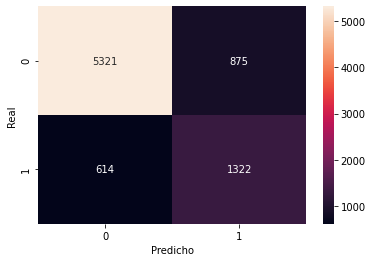

Recall: 0.68
Precision: 0.6
Acc: 0.82
Roc: 0.88


In [6]:
arbol_seleccion_de_variables = tree.DecisionTreeClassifier(class_weight = {0: 1, 1: 2}, criterion = 'gini',min_samples_leaf = 250,
                                 max_depth = 9, random_state = 1971915)

arbol_seleccion_de_variables.fit(X_train,y_train)

metricas(y_test,arbol_seleccion_de_variables.predict(X_test),X_test,arbol_seleccion_de_variables)

## Otro Preprocesamiento: Reduccion de dimensionalidad 

En la primera parte hicimos un preprocesamiento manual, utilizando los que sabemos sobre el dataset gracias a la primera parte del trabajo práctico. Ahora buscamos utilizar otras herramientas para ver si podemos mejorar el preprocesamiento.

In [7]:
from preprocesamiento import preprocesar_df_min_max_scaler
from preprocesamiento import preprocesar_df_pca

df = obtenerDFTraining()
X, y = preprocesar_data_frame(df)
X = preprocesar_df_min_max_scaler(X[['ganancia_perdida_declarada_bolsa_argentina','trabajo',
                                      'estado_marital','genero',"anios_estudiados"]])
X = preprocesar_df_pca(X,18)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [8]:
parametros = {'criterion' : ('gini','entropy') , 'max_depth':range(2,10), 
              'min_samples_leaf':(1,200,300,500,1000,1500,2000),
              "class_weight" :  [{0: 1,1: 1},{0: 1,1: 1.25},{0: 1,1: 1.5},{0: 1,1: 2}],
              'random_state':[RANDOM_STATE]} 

arbol = tree.DecisionTreeClassifier()
arbol_pca = GridSearchCV(arbol, parametros, scoring = "roc_auc",n_jobs= -1, verbose = 0, cv= 10)

arbol_pca.fit(x_train, y_train)


print(classification_report(y_test,arbol_pca.predict(x_test)))
arbol_pca.best_params_

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      6196
           1       0.64      0.62      0.63      1936

    accuracy                           0.83      8132
   macro avg       0.76      0.76      0.76      8132
weighted avg       0.82      0.83      0.83      8132



{'class_weight': {0: 1, 1: 1.25},
 'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_leaf': 1,
 'random_state': 1971915}

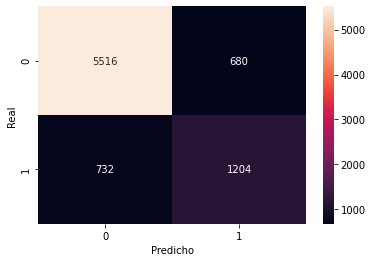

Recall: 0.62
Precision: 0.64
Acc: 0.83
Roc: 0.87


In [9]:
arbol_pca =tree.DecisionTreeClassifier(class_weight = {0: 1, 1: 1.25}, criterion = 'entropy',min_samples_leaf = 1,
                                 max_depth = 9, random_state = 1971915)

arbol_pca.fit(x_train,y_train)

metricas(y_test,arbol_pca.predict(x_test),x_test,arbol_pca)

Como podemos ver este ultimo modelo predice mejor que el anterior, de modo que decidimos quedarnos con el.

Preprocesamiento:
+ Seleccion de variables
+ MinMaxEscaler
+ PCA

Hiperparametros:
+ peso de clases --> {0: 1, 1: 1.25}
+ criterio  --> entropy
+ maxima profundidad --> 9
+ minimo de instancias en nodos --> 1

### Prediccion sobre el Holdout

In [11]:
holdout = obtenerDFHoldout()

ids = np.array(holdout['id'])

holdout = preprocesar_df_min_max_scaler(holdout[['ganancia_perdida_declarada_bolsa_argentina','trabajo',
                                      'estado_marital','genero',"anios_estudiados"]])
holdout = preprocesar_df_pca(holdout,18)
predicciones_holdout = arbol_pca.predict(holdout)
escribir_predicciones_a_archivo(predicciones_holdout,"Arbol de Decision",ids)